In [1]:
import os
os.chdir('../')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from utils.vis_utils import vis_cross_play_matrix, plot_sp_by_xp, \
    vis_nk_curve, get_selfplay_scores, get_ood_gen_scores
# reload modules
%load_ext autoreload
%autoreload 2

## Visualize Results Tables

In [ ]:
base_path = "/scratch/cluster/clw4542/explore_marl/open_marl_results/"
algorithms = {  # format is alg log name: display name      
    "vdn": "vdn", 
    "qmix": "qmix",
    "iql": "iql",
    "ippo": "ippo", 
    "mappo": "mappo", 
    "poam": "poam-aht",
    "ippo-naht": "ippo-naht",
    "poam": "poam",
}

n_runs = 5
for log_folder, n_agents in {
    "mpe-pp/ts=100_shape=0.01": 3, 
    "5v6": 5, 
    "8v9": 8, 
    "10v11": 10,
    "3s5z": 3,
}.items():
    print("Setting: ", log_folder)
    df = vis_cross_play_matrix(log_path=os.path.join(base_path, log_folder, "open_eval_best"), 
                               algorithms=algorithms,
                               # algs to compute the xp score with
                               eval_algs=["vdn", "qmix", "iql", "ippo", "mappo"], # TODO: enable specifying the seed of teammate as well
                               n_expected_evals=n_runs*(n_agents - 1),
                               vis_table_colors=True,
                               rm_empty_evals=True,
                               rm_duplicates=True,
                               save=True,
                               savedir="../../open_marl_results/figures/5trials-95ci",
                               savename=f"{log_folder.replace('/', '_')}_xp-matrix.png", 
                               verbose=True
                               )
    
    display(df)
    # plot_sp_by_xp(df, algorithms, xp_col_name="XP score (mean +/- std)",
    #               task=log_folder, legend_loc=(0.85, -0.25))

print("Note: all scores are the mean +/- 95% CI")

Setting:  8v9


,vdn,qmix,iql,ippo,mappo,poam,mean xp score
vdn,19.788 +/- (0.036),18.631 +/- (0.207),15.520 +/- (0.838),16.899 +/- (0.571),14.999 +/- (0.952),18.202 +/- (0.325),16.512 +/- (0.422)
qmix,18.631 +/- (0.207),19.811 +/- (0.035),15.754 +/- (0.819),17.588 +/- (0.477),15.338 +/- (0.799),18.705 +/- (0.286),16.828 +/- (0.385)
iql,15.520 +/- (0.838),15.754 +/- (0.819),18.854 +/- (0.093),14.229 +/- (0.863),12.995 +/- (0.878),17.564 +/- (0.273),14.625 +/- (0.463)
ippo,16.899 +/- (0.571),17.588 +/- (0.477),14.229 +/- (0.863),19.093 +/- (0.163),15.390 +/- (0.825),17.899 +/- (0.345),16.027 +/- (0.413)
mappo,14.999 +/- (0.952),15.338 +/- (0.799),12.995 +/- (0.878),15.390 +/- (0.825),19.795 +/- (0.037),15.031 +/- (1.050),14.680 +/- (0.462)
poam,18.202 +/- (0.325),18.705 +/- (0.286),17.564 +/- (0.273),17.899 +/- (0.345),15.031 +/- (1.050),19.077 +/- (0.177),17.480 +/- (0.309)


Setting:  10v11


,vdn,qmix,iql,ippo,mappo,poam,mean xp score
vdn,19.868 +/- (0.021),18.980 +/- (0.260),18.276 +/- (0.274),18.638 +/- (0.197),16.453 +/- (0.864),19.444 +/- (0.093),18.087 +/- (0.280)
qmix,18.980 +/- (0.260),19.884 +/- (0.034),17.348 +/- (0.453),18.193 +/- (0.311),18.608 +/- (0.370),19.511 +/- (0.138),18.282 +/- (0.199)
iql,18.276 +/- (0.274),17.348 +/- (0.453),18.901 +/- (0.279),16.610 +/- (0.547),16.206 +/- (0.692),18.751 +/- (0.344),17.110 +/- (0.282)
ippo,18.638 +/- (0.197),18.193 +/- (0.311),16.610 +/- (0.547),18.971 +/- (0.112),17.048 +/- (0.559),18.910 +/- (0.282),17.622 +/- (0.247)
mappo,16.453 +/- (0.864),18.608 +/- (0.370),16.206 +/- (0.692),17.048 +/- (0.559),19.862 +/- (0.039),17.511 +/- (0.793),17.079 +/- (0.351)
poam,19.444 +/- (0.093),19.511 +/- (0.138),18.751 +/- (0.344),18.910 +/- (0.282),17.511 +/- (0.793),19.881 +/- (0.023),18.826 +/- (0.207)


Note: all scores are the mean +/- 95% CI


## Matched vs Mismatched Seeds for Self Play

Setting:  5v6


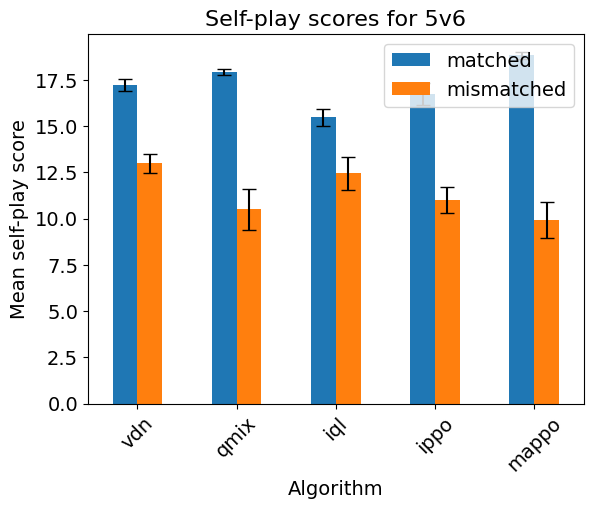

Setting:  mpe-pp/ts=100_shape=0.01


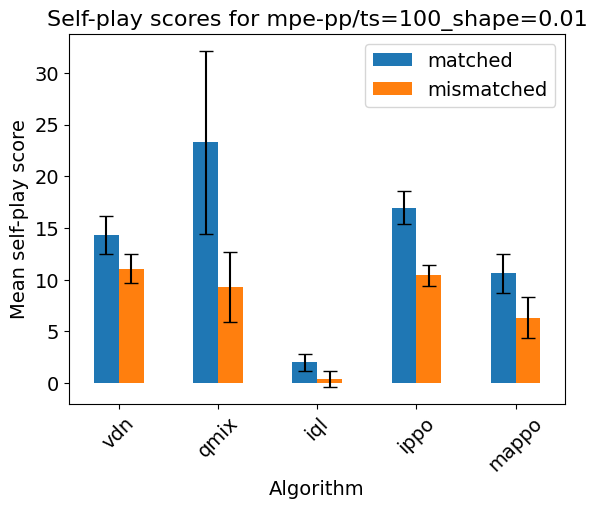

In [ ]:
normalize = True
base_path = "/scratch/cluster/clw4542/explore_marl/open_marl_results/"
algorithms = [        
    "vdn",
    "qmix",
    "iql",
    "ippo", 
    "mappo", 
]
n_runs = 5
for log_folder, n_agents in {
    "5v6": 5, 
    "8m": 8,
    "8v9": 8, 
    "3s5z": 3,
    "mpe-pp/ts=100_shape=0.01": 3
}.items():
    print("Setting: ", log_folder)
    # std ERRORS
    sp_scores_matched_means, sp_scores_matched_cis = get_selfplay_scores(log_path=os.path.join(base_path, log_folder, "open_eval_best"), 
                                    algorithms=algorithms,
                                    n_expected_evals=n_runs*(n_agents - 1),
                                    remove_empty_evals=False,
                                    require_matched_seeds=False)
    sp_scores_mismatched_means, sp_scores_mismatched_cis  = get_selfplay_scores(log_path=os.path.join(base_path, log_folder, "selfplay_mismatched_eval_best"),
                                    algorithms=algorithms,
                                    n_expected_evals=n_runs*(n_agents - 1),
                                    remove_empty_evals=False,
                                    require_matched_seeds=False)
    
    # plot double bar chart of sp_scores_matched and sp_scores_mismatched. Both dicts have the same keys 
    # (algorithms) and values (means and stds of self-play scores across runs)

    fig, ax = plt.subplots()
    s1 = pd.Series(sp_scores_matched_means, name='matched')
    s2 = pd.Series(sp_scores_mismatched_means, name='mismatched')
    
    sp_df = pd.concat([s1, s2], axis=1)
    sp_df.columns = ['matched', 'mismatched']
    bars = sp_df.plot(kind='bar', ax=ax)

    # Calculate the x positions for the matched and mismatched groups
    bar_width = bars.patches[0].get_width()
    n_bars = len(sp_df)
    indices = range(n_bars)
    x_positions_matched = [bar.get_x() + bar_width/2 for bar in bars.patches[:n_bars]]
    x_positions_mismatched = [bar.get_x() + bar_width * 1.5 for bar in bars.patches[:n_bars]]

    # Add error bars
    ax.errorbar(x_positions_matched, sp_scores_matched_means.values(), 
               yerr=sp_scores_matched_cis.values(), 
               fmt='none', capsize=5, color='black')
    ax.errorbar(x_positions_mismatched, sp_scores_mismatched_means.values(), 
                yerr=sp_scores_mismatched_cis.values(), 
                fmt='none', capsize=5, color='black')

    # tilt x axis tick labels 
    plt.xticks(rotation=45)
    ax.set_ylabel("Mean self-play score")
    ax.set_xlabel("Algorithm")
    ax.set_title(f"Self-play scores for {log_folder}")
    plt.legend(loc="upper right")
    plt.show()


# OOD Generalization Evaluation

In [ ]:
base_path = "/scratch/cluster/clw4542/explore_marl/open_marl_results/"
exp_namemap = { # format is alg log name: display name
        "ippo-aht": "ippo aht",
        "poam-aht": "poam aht",
        "ippo-naht": "ippo naht",
        "poam": "poam",
}

target_algs = [        
    "vdn", 
    "qmix",
    "iql",
    "ippo", 
    "mappo", 
]

n_eval_alg_seeds = 3
n_target_alg_seeds = 2
for log_folder, algs_to_eval in {
    "5v6": ["ippo-nocmask-pqvmq_open", "liam-nocmask-pqvmq_open"], 
    "8v9": ["ippo-pqvmq_open", "liam-pqvmq_open"], 
    "3s5z": ["ippo-pqvmq_open", "liam-pqvmq_open"],
    "10v11": ["ippo-pqvmq_open", "liam-pqvmq_open"]
}.items():
    print("Setting: ", log_folder)
    # std ERRORS
    n_agents = log_folder.split("v")[0]
    ood_gen_means, ood_gen_cis = get_ood_gen_scores(log_path=os.path.join(base_path, log_folder, "ood_generalization"), 
                                    algs_to_eval=algs_to_eval,
                                    target_algs=target_algs,
                                    n_expected_evals=n_eval_alg_seeds* n_target_alg_seeds * (n_agents - 1),
                                    remove_empty_evals=True
                                    )
    # ood_gen_dict has structure {alg_to_eval: {target_alg: [ood_gen_scores]}}
    # Extract target algorithms and sort them for consistent plotting
    target_algs = sorted({target_alg for algs_to_eval in ood_gen_means.values() for target_alg in algs_to_eval})
    # Extract alg_to_eval names
    alg_to_eval_names = sorted(ood_gen_means.keys())

    # Organize data for plotting
    scores = {alg: [] for alg in target_algs}
    for target_alg in target_algs:
        for alg_name in alg_to_eval_names:
            scores[target_alg].append(ood_gen_means.get(alg_name, {}).get(target_alg, 0))

    # Plotting
    fig, ax = plt.subplots()
    n_groups = len(target_algs)
    index = np.arange(n_groups)
    bar_width = 0.3
    opacity = 0.8

    for i, alg_name in enumerate(alg_to_eval_names):
        plt.bar(index + i * bar_width, [scores[alg][i] for alg in target_algs], bar_width,
                alpha=opacity, label=exp_namemap[alg_name])
        # add standard errors 
        plt.errorbar(index + i * bar_width, [scores[alg][i] for alg in target_algs], 
                    yerr=[ood_gen_cis.get(alg_name, {}).get(target_alg, 0) for alg in target_algs], 
                    fmt='none', capsize=5, color='black')

    plt.xlabel('Target Algorithm')
    plt.ylabel('Mean Return')
    plt.title(f'OOD Scores on {log_folder}')
    plt.xticks(index + bar_width / 2, target_algs, rotation=0, ha="right")
    plt.legend(
        loc="lower right",
        # bbox_to_anchor=(1.0, -0.25),
        ncol=2,
    )
    plt.show()  

## Visualize N-k Curves

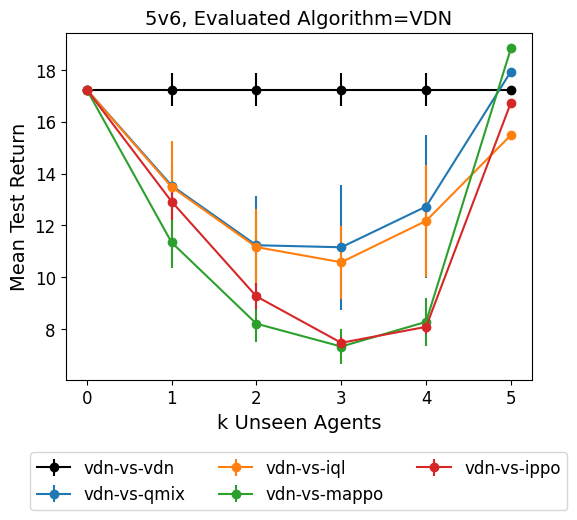

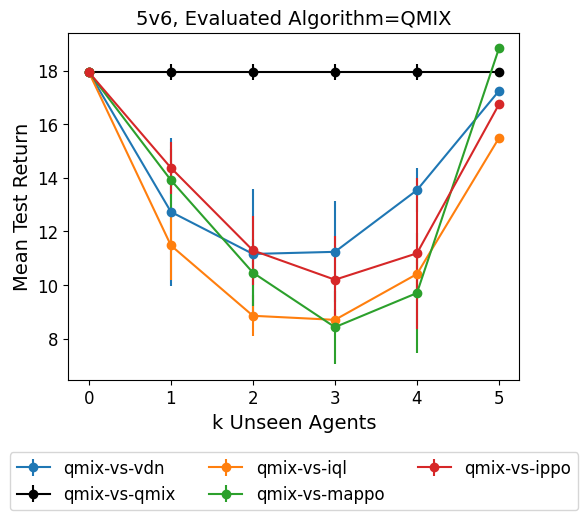

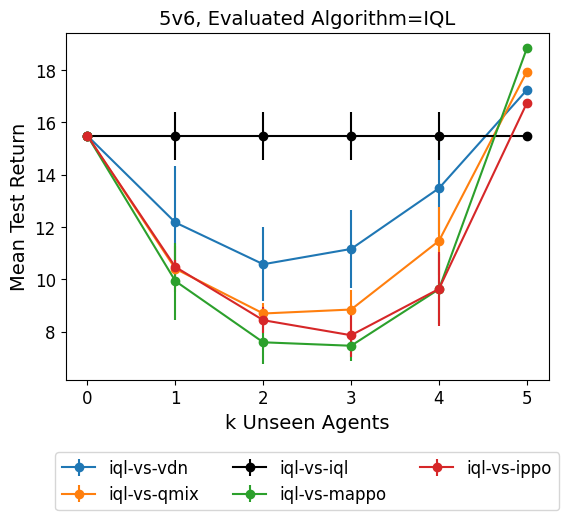

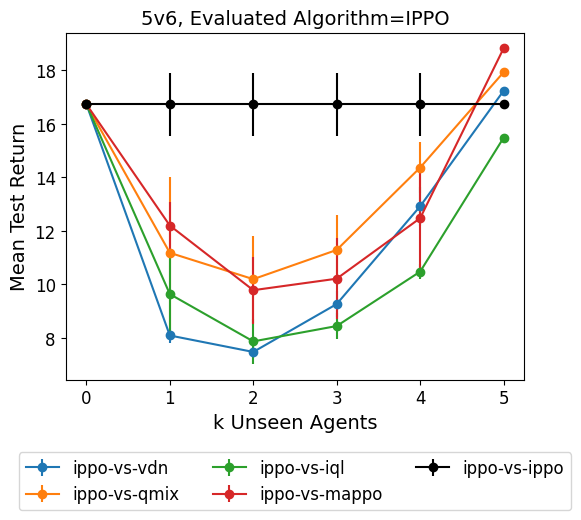

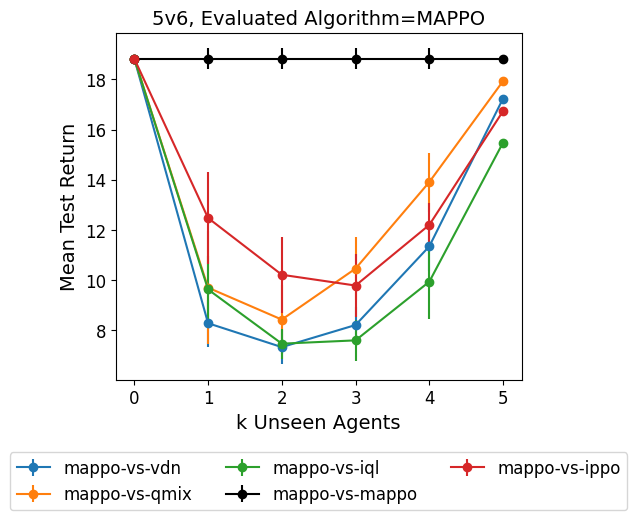

In [18]:
task = "5v6"
log_path = os.path.join(base_path, task, "open_eval_best")
algorithms = [        
    "vdn", 
    "qmix",
    "iql",
    "ippo", 
    "mappo", 
]

for algo in algorithms:
    vis_nk_curve(log_path, algo=algo, 
                target_algs=algorithms,
                n=5, title=task,
                save=False,
                savedir=os.path.join(base_path, "figures", task)
    )